In [1]:
using Pkg
Pkg.activate(".")
using SemanticModels
using SemanticModels.Unitful: DomainError, s, d, C, uconvert, NoUnits
using DifferentialEquations
using DataFrames
using Unitful
using Test

using Distributions: Uniform
using GLM
using DataFrames


In [2]:
using Plots

In [3]:
stripunits(x) = uconvert(NoUnits, x)

stripunits (generic function with 1 method)

In [11]:
function flusim(tfinal)
    # annual cycle of temperature control flu infectiousness
    springmodel = SpringModel([u"(1.0/(365*8))d^-2"], # parameters (frequency)
                              (u"0d",tfinal), # time domain
                              [u"25.0C", u"0C/d"]) # initial_conditions T, T'
    function create_sir(m, solns)
        sol = solns[1]
        initialS = u"10000person"
        initialI = u"1person" 
        initialpop = [initialS, initialI, u"0.0person"]
        β = u"1.0/18"/u"d*C" * sol(sol.t[end-2])[1] #infectiousness
        @show β
        sirprob = SIRSimulation(initialpop, #initial_conditions S,I,R
                                (u"0.0d", u"20d"), #time domain
                                SIRParams(β, u"40.0person/d")) # parameters β, γ
        return sirprob
    end

    function create_flu(cm, solns)
        sol = solns[1]
        finalI = stripunits(sol(u"8.0d")[2]) # X
        population = stripunits(sol(sol.t[end])[2])
        # population = stripunits(sum(sol.u[end]))
        df = SemanticModels.generate_synthetic_data(population, 0,100)
        f = @formula(vaccines_produced ~ flu_patients)
        model =  lm(f,
            df[2:length(df.year),
            [:year, :flu_patients, :vaccines_produced]])
        println("GLM Model:")
        println(model)

        year_to_predict = 1
        num_flu_patients_from_sim = finalI
        vaccines_produced = missing
        targetDF = DataFrame(year=year_to_predict,
            flu_patients=num_flu_patients_from_sim, 
            vaccines_produced=missing)
        @show targetDF


        return RegressionProblem(f, model, targetDF, missing)
    end
    cm = CombinedModel([springmodel], create_sir)
    flumodel = CombinedModel([cm], create_flu)
    return flumodel
end

tfinal = 240π*u"d" #(~2 yrs)
flumodel = flusim(tfinal)


CombinedModel{Array{CombinedModel{Array{SpringModel{Array{Quantity{Float64,𝐓^-2,Unitful.FreeUnits{(d^-2,),𝐓^-2,nothing}},1},Tuple{Quantity{Int64,𝐓,Unitful.FreeUnits{(d,),𝐓,nothing}},Quantity{Float64,𝐓,Unitful.FreeUnits{(d,),𝐓,nothing}}},Array{Quantity{Float64,D,U} where U where D,1}},1},getfield(Main, Symbol("#create_sir#9"))},1},getfield(Main, Symbol("#create_flu#10"))}(CombinedModel{Array{SpringModel{Array{Quantity{Float64,𝐓^-2,Unitful.FreeUnits{(d^-2,),𝐓^-2,nothing}},1},Tuple{Quantity{Int64,𝐓,Unitful.FreeUnits{(d,),𝐓,nothing}},Quantity{Float64,𝐓,Unitful.FreeUnits{(d,),𝐓,nothing}}},Array{Quantity{Float64,D,U} where U where D,1}},1},getfield(Main, Symbol("#create_sir#9"))}[CombinedModel{Array{SpringModel{Array{Quantity{Float64,𝐓^-2,FreeUnits{(d^-2,),𝐓^-2,nothing}},1},Tuple{Quantity{Int64,𝐓,FreeUnits{(d,),𝐓,nothing}},Quantity{Float64,𝐓,FreeUnits{(d,),𝐓,nothing}}},Array{Quantity{Float64,D,U} where U where D,1}},1},#create_sir#9}(SpringModel{Array{Quantity{Float64,𝐓^-2,Unitful.FreeUnits{

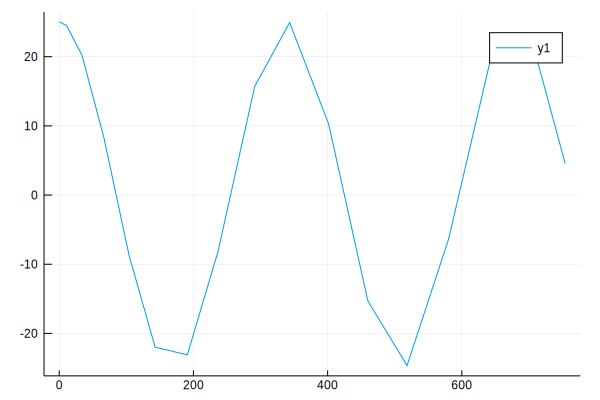

In [12]:
springmodel = flumodel.deps[1].deps[1]
sirmodel = flumodel.deps[1]
sol = solve(springmodel)
plot(sol.t./d, map(x->x[1], sol.u) ./ C)

In [13]:
sirsol = solve(sirmodel)

β = 1.0854014119706108 d^-1


retcode: Success
Interpolation: specialized 9th order lazy interpolation
t: 16-element Array{Quantity{Float64,𝐓,Unitful.FreeUnits{(d,),𝐓,nothing}},1}:
                0.0 d
 0.2503747748877873 d
 0.9420079061012359 d
 1.9002912698756584 d
  2.972126338526902 d
  4.147568957524303 d
  5.418240373678765 d
 6.7948860959760315 d
  8.400900825017708 d
 10.236958450599571 d
  12.30882380127413 d
 13.728455901957311 d
 15.710893594828972 d
  17.26796601078083 d
 19.522036174270298 d
               20.0 d
u: 16-element Array{Array{Quantity{Float64,NoDims,Unitful.FreeUnits{(person,),NoDims,nothing}},1},1}:
 [10000.0 person, 1.0 person, 0.0 person]           
 [9999.69 person, 1.31091 person, 0.00115006 person]
 [9998.22 person, 2.76907 person, 0.0065442 person] 
 [9993.17 person, 7.80133 person, 0.0251661 person] 
 [9976.09 person, 24.8203 person, 0.0882149 person] 
 [9912.76 person, 87.9172 person, 0.322914 person]  
 [9661.17 person, 338.559 person, 1.27032 person]   
 [8652.58 person, 1343.0

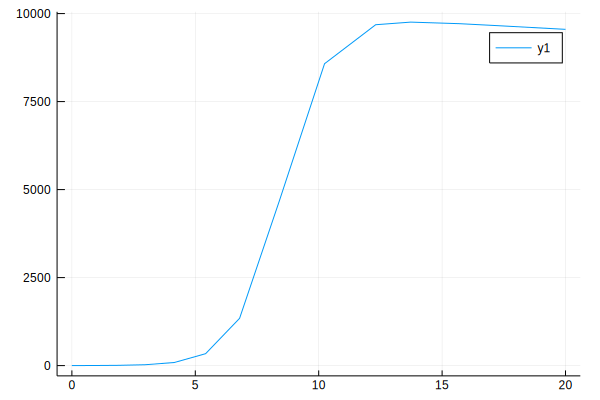

In [14]:
plot(sirsol.t./d,map(x->stripunits.(x)[2], sirsol.u))

In [15]:
sol = solve(flumodel)

β = 1.0854014119706108 d^-1
GLM Model:
StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: vaccines_produced ~ 1 + flu_patients

Coefficients:
                 Estimate Std.Error    t value Pr(>|t|)
(Intercept)       4892.06   342.292    14.2921   <1e-24
flu_patients  -0.00529781 0.0655031 -0.0808788   0.9357

targetDF = 1×3 DataFrame
│ Row │ year  │ flu_patients │ vaccines_produced │
│     │ Int64 │ Float64      │ Missing           │
├─────┼───────┼──────────────┼───────────────────┤
│ 1   │ 1     │ 3627.46      │ missing           │


┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Any,Any}) at modelframe.jl:124
└ @ StatsModels /Users/jamesfairbanks/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124
┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = getmaxwidths(::DataFrame, ::UnitRange{Int64}, ::UnitRange{Int64}, ::Symbol) at show.jl:105
└ @ DataFrames /Users/jamesfairbanks/.julia/packages/DataFrames/5Rg4Y/src/abstractdataframe/show.jl:105
┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Symbol,StatsModels.ContrastsMatrix}) at modelframe.jl:124
└ @ StatsModels /Users/jamesfairbanks/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


1-element Array{Union{Missing, Float64},1}:
 4872.838053691122